# Data Science Research Methods - Final Report

The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer etc) performed by 9 subjects wearing 3 inertial measurement units (IMU) and a heart rate monitor. This data is stored in individual text files per subject. Each row in each file represents one reading and contains 54 attributes (including timestamp, activity ID, heart rate and IMU sensory data). Please see the Report2_data_info.pdf supplied with the dataset for information about the different attributes and how the dataset was collected.

**Assuming the goal is to develop hardware and/or software which can determine the amount (using start/end times and heart rates) and type of physical activity carried out by an individual, what actionable insights can you derive from the dataset?**

You are required to:

1. **Carry out thorough exploratory data analysis and appropriately handle missing or dirty data.**
2. **Develop and test at least one hypothesis for a relationship between a single pair of attributes.**
3. **Develop and test at least one model which uses multiple attributes to make predictions.**

For this assessment you must submit a .zip file containing two files - the Jupyter notebook (.ipynb), and a .pdf of the notebook exported.\

In [ ]:
# General useful tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime

#Hypothesis testing
from scipy.stats import norm, zscore

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Regression classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

# Cluster Analysis
from sklearn.cluster import KMeans

# Exploratory Data Analysis (EDA)

## Importing the dataset

Each of the data-files contains 54 columns per row, the columns contain the following data:

– 1 timestamp (s)

– 2 activityID (see II.2. for the mapping to the activities)

– 3 heart rate (bpm)

– 4-20 IMU hand

– 21-37 IMU chest

– 38-54 IMU ankle

**IMU sub-labels:**
- 1 temperature (°C)
- 2-4 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
- 5-7 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
- 8-10 3D-gyroscope data (rad/s)
- 11-13 3D-magnetometer data (μT)
- 14-17 orientation (invalid in this data collection)

In [ ]:
# Creating headers to the dataset
headers = ['timestamp', 'activityID', 'bpm']
cats = ['hand', 'chest', 'ankle']

for cat in cats:
    for i in range(17):
        if i == 0:
            headers.append(cat + '_temp')
        elif i < 2:
            headers.append(cat + '_acc_16_x')
        elif i < 3:
            headers.append(cat + '_acc_16_y')
        elif i < 4:
            headers.append(cat + '_acc_16_z')
        elif i < 5:
            headers.append(cat + '_acc_6_x')
        elif i < 6:
            headers.append(cat + '_acc_6_y')
        elif i < 7:
            headers.append(cat + '_acc_6_z')
        elif i < 8:
            headers.append(cat + '_gyro_x')
        elif i < 9:
            headers.append(cat + '_gyro_y')
        elif i < 10:
            headers.append(cat + '_gyro_z')
        elif i < 11:
            headers.append(cat + '_mag_x')
        elif i < 12:
            headers.append(cat + '_mag_y')
        elif i < 13:
            headers.append(cat + '_mag_z')
        else:
            headers.append(cat + '_orientation_')


# Creating unique values for each
dups = pd.DataFrame(headers).duplicated(keep=False)
n = 0
for i, dup in enumerate(dups):
    if dup == True:
        headers[i] = headers[i] + str(n)
        n += 1

subjects = pd.DataFrame()
for i in range(101, 110):
    root = 'subject'
    path = root + str(i) + '.dat'
    subject = pd.read_csv(path, sep='\s+', names=headers)
    subject['id'] = i  # We are adding one column to the headers, meaning that there will be 55 columns in the initial dataset 
    subjects = subjects.append(subject, sort=False)
subjects.reset_index(drop=True, inplace=True)

display(subjects)

,timestamp,activityID,bpm,hand_temp,hand_acc_16_x,hand_acc_16_y,hand_acc_16_z,hand_acc_6_x,hand_acc_6_y,hand_acc_6_z,...,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_orientation_8,ankle_orientation_9,ankle_orientation_10,ankle_orientation_11,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029207,109


In [ ]:
subject_info = pd.DataFrame([
    ['Male', 27, 182, 83, 75, 193, 'right'],
    ['Female', 25, 169, 78, 74, 195, 'right'],
    ['Male', 31, 187, 92, 68, 189, 'right'],
    ['Male', 24, 194, 95, 58, 196, 'right'],
    ['Male', 26, 180, 73, 70, 194, 'right'],
    ['Male', 26, 183, 69, 60, 194, 'right'],
    ['Male', 23, 173, 86, 60, 197, 'right'],
    ['Male', 32, 179, 87, 66, 188, 'left'],
    ['Male', 31, 168, 65, 54, 189, 'right']], 
    index=range(101, 110),                       
    columns=['Sex', 'Age', 'Height (cm)', 'Weight (kg)', 'Resting HR (bpm)', 'Max HR (bpm)', 'Dominant hand'])

subject_info

,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand
101,Male,27,182,83,75,193,right
102,Female,25,169,78,74,195,right
103,Male,31,187,92,68,189,right
104,Male,24,194,95,58,196,right
105,Male,26,180,73,70,194,right
106,Male,26,183,69,60,194,right
107,Male,23,173,86,60,197,right
108,Male,32,179,87,66,188,left
109,Male,31,168,65,54,189,right


## Data Cleaning

### Summary of collected data
This is a realistic dataset, therefore some data is missing. 
**Missing data had 2 main reason:**

– **Data dropping due to using wireless sensors.** This however only occurred very rarely: the 3
IMUs had a “real” sampling frequency of 99.63Hz, 99.89Hz and 99.65Hz for hand, chest and
ankle IMU placement, respectively.

– **Problems with the hardware setup, causing e.g. connection loss to the dongles or system crash.**
Due to these problems, some activities for certain subjects are partly or completely missing.
Altogether, over 10 hours of data were collected, from which nearly 8 hours were labeled as 1 of the 18
activities performed during data collection.

In [ ]:
# Removing the Orientation-columns (ref: readme.pdf)
subjects = subjects[subjects.columns.drop(list(subjects.filter(regex='orientation')))]

# More information on activityID on "DescriptionOfActivities.pdf"
subjects = subjects.drop(subjects[subjects['activityID'] == 0].index)   # Removing activityID's 0 (ref: readme.pdf)

activities = {'lying': 1, 'sitting': 2, 'standing': 3, 'walking': 4, 
              'running': 5, 'cycling':6, 'nordic_walking': 7,
              'watching_tv': 9, 'computer_work': 10,  'car_driving': 11, 
              'ascending_stairs': 12, 'descending_stairs': 13,
              'vacuum_cleaning': 16, 'ironing': 17, 'folding_laundry':18, 
              'house_cleaning': 19, 'football': 20, 'rope_jumping': 24}

for key, value in activities.items():
    subjects['activityID'].replace(value, key, inplace=True)

In [ ]:
subjects['activityID'].value_counts()

walking              238761
ironing              238690
lying                192523
standing             189931
nordic_walking       188107
sitting              185188
vacuum_cleaning      175353
cycling              164600
ascending_stairs     117216
descending_stairs    104944
running               98199
rope_jumping          49360
Name: activityID, dtype: int64

In [ ]:
subjects.isnull().sum()

timestamp               0
activityID              0
bpm               1765464
hand_temp           11124
hand_acc_16_x       11124
hand_acc_16_y       11124
hand_acc_16_z       11124
hand_acc_6_x        11124
hand_acc_6_y        11124
hand_acc_6_z        11124
hand_gyro_x         11124
hand_gyro_y         11124
hand_gyro_z         11124
hand_mag_x          11124
hand_mag_y          11124
hand_mag_z          11124
chest_temp           2420
chest_acc_16_x       2420
chest_acc_16_y       2420
chest_acc_16_z       2420
chest_acc_6_x        2420
chest_acc_6_y        2420
chest_acc_6_z        2420
chest_gyro_x         2420
chest_gyro_y         2420
chest_gyro_z         2420
chest_mag_x          2420
chest_mag_y          2420
chest_mag_z          2420
ankle_temp           8507
ankle_acc_16_x       8507
ankle_acc_16_y       8507
ankle_acc_16_z       8507
ankle_acc_6_x        8507
ankle_acc_6_y        8507
ankle_acc_6_z        8507
ankle_gyro_x         8507
ankle_gyro_y         8507
ankle_gyro_z

The IMU sensors on the hands, ankles and chest aren't that many, so we can safely remove them without compromising the dataset.
The missing values in the heart rate (bmp) on the other hand is quite substantial, so here we want to fill the data rather than remove it.

In [ ]:
na_cols = [col for col in subjects.columns if 'hand' in col or 'chest' in col or 'ankle' in col]

for col in na_cols:
    subjects = subjects.dropna(subset=[col])

In [ ]:
# Subject 109 has very few bpm-values as is.
subjects.groupby('id')['bpm'].count()

id
101    22590
102    23691
103    15841
104    20863
105    24592
106    22659
107    21055
108    23624
109      583
Name: bpm, dtype: int64

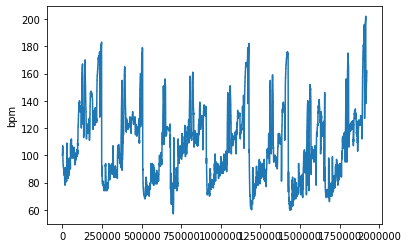

In [ ]:
# I want to use the interpolate function on bpm, but first I need to look at how bpm acts before
# determining which method to use.
sns.lineplot(range(len(subjects['bpm'])), subjects['bpm'])

In [ ]:
subjects = subjects.interpolate(method='linear') # Replacing NaN with the mean of values right before and just after.

We have now dropped all missing values for the IMU measurement units and interpolated all missing values in the heart-rate feature and we can see that it hasn't changed the picture of our bpm.

In [ ]:
subjects.isnull().sum()

timestamp         0
activityID        0
bpm               4
hand_temp         0
hand_acc_16_x     0
hand_acc_16_y     0
hand_acc_16_z     0
hand_acc_6_x      0
hand_acc_6_y      0
hand_acc_6_z      0
hand_gyro_x       0
hand_gyro_y       0
hand_gyro_z       0
hand_mag_x        0
hand_mag_y        0
hand_mag_z        0
chest_temp        0
chest_acc_16_x    0
chest_acc_16_y    0
chest_acc_16_z    0
chest_acc_6_x     0
chest_acc_6_y     0
chest_acc_6_z     0
chest_gyro_x      0
chest_gyro_y      0
chest_gyro_z      0
chest_mag_x       0
chest_mag_y       0
chest_mag_z       0
ankle_temp        0
ankle_acc_16_x    0
ankle_acc_16_y    0
ankle_acc_16_z    0
ankle_acc_6_x     0
ankle_acc_6_y     0
ankle_acc_6_z     0
ankle_gyro_x      0
ankle_gyro_y      0
ankle_gyro_z      0
ankle_mag_x       0
ankle_mag_y       0
ankle_mag_z       0
id                0
dtype: int64

Still 4 missing values. Interpolation calculates values before and after the NaN-values, so if the first and last values are NaN they will not change. Because there are only 4 values I feel safe with removing them without compromising the dataset.

In [ ]:
subjects = subjects.dropna()

In [ ]:
# Looking for duplicated feature rows
subjects.duplicated().sum()

0

In [ ]:
subjects.groupby('id')['bpm'].count()

id
101    247204
102    259128
103    173341
104    228385
105    269311
106    248080
107    230377
108    259215
109      6386
Name: bpm, dtype: int64

# Exploratory Data Analysis (EDA)

## Boxplot

The boxplot will show the distribution of all features in every label.

In order to see all features I will first standardize the dataset. By standardizing the data we make it easier to feature labels with really big values and really small values. 

In [ ]:
numeric_cols = subjects.drop(['activityID'], axis=1)  # Need to drop activityID seeing as it is not a numeric feature label
scaler = StandardScaler().fit(numeric_cols)
scaled_subjects = scaler.transform(numeric_cols)

scaled_subjects = pd.DataFrame(scaled_subjects)
scaled_subjects.columns = numeric_cols.columns
scaled_subjects.head()

,timestamp,bpm,hand_temp,hand_acc_16_x,hand_acc_16_y,hand_acc_16_z,hand_acc_6_x,hand_acc_6_y,hand_acc_6_z,hand_gyro_x,...,ankle_acc_6_x,ankle_acc_6_y,ankle_acc_6_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,id
0,-1.518731,-0.271715,-1.332558,1.160907,0.534777,0.626153,1.134043,0.558287,0.546725,-0.053495,...,0.047972,-0.235685,0.713666,-0.006002,-0.023501,-0.003943,-1.559988,-1.776032,-3.803652,-1.529699
1,-1.518722,-0.271715,-1.332558,1.124092,0.534934,0.605838,1.131667,0.553718,0.562061,0.047452,...,0.040533,-0.235683,0.718108,-0.003825,0.011192,0.001304,-1.621021,-1.769201,-3.796838,-1.529699
2,-1.518713,-0.271715,-1.332558,1.178627,0.584106,0.587387,1.139283,0.592717,0.565735,0.143184,...,0.052959,-0.237795,0.722381,0.025623,0.002712,-0.004213,-1.633335,-1.768684,-3.809272,-1.529699
3,-1.518704,-0.271715,-1.332558,1.165254,0.589415,0.528700,1.151589,0.620195,0.561785,0.150342,...,0.043026,-0.237797,0.722473,-0.016439,0.027431,0.002520,-1.634521,-1.732210,-3.877775,-1.529699
4,-1.518695,-0.271715,-1.332558,1.152867,0.611471,0.508829,1.146737,0.629406,0.542618,0.153185,...,0.043027,-0.231447,0.722431,0.027880,0.085874,-0.006730,-1.645419,-1.778425,-3.815561,-1.529699


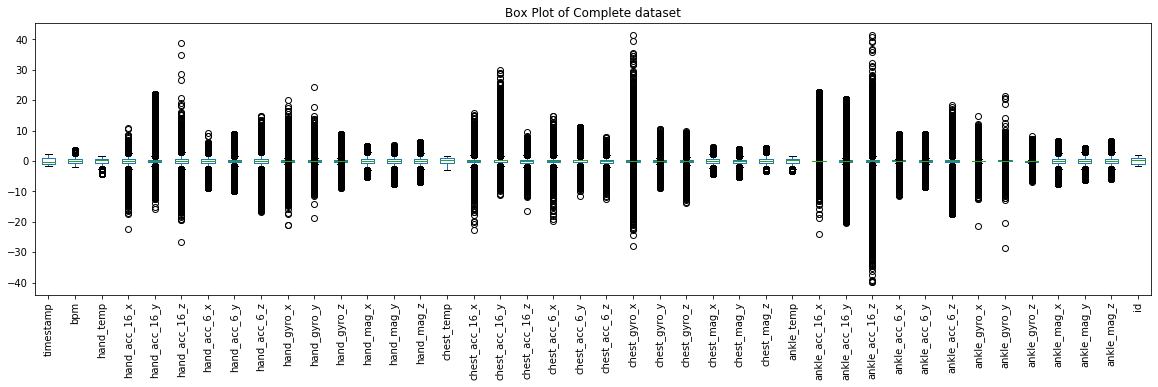

In [ ]:
scaled_subjects.plot(kind='box', figsize=(20,5), title='Box Plot of Complete dataset')
plt.xticks(rotation=90)
plt.show()

Even though there are a lot of outliers in the dataset I don't want to remove any of them. The distribution may have many outliers, but they don't look to deviate from the rest of the features.

## Shape and size or the dataset

In [ ]:
subjects.reset_index(drop=True, inplace=True)
print('Size: ', subjects.size)
print('Shape: ', subjects.shape)
print('N columns: ', len(subjects.columns))

Size:  82621361
Shape:  (1921427, 43)
N columns:  43


In [ ]:
display(subjects)

,timestamp,activityID,bpm,hand_temp,hand_acc_16_x,hand_acc_16_y,hand_acc_16_z,hand_acc_6_x,hand_acc_6_y,hand_acc_6_z,...,ankle_acc_6_x,ankle_acc_6_y,ankle_acc_6_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,id
0,37.70,lying,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.122500,-57.884700,101
1,37.71,lying,100.0,30.375,2.07165,7.25965,6.01218,2.19238,7.21038,6.01604,...,9.60177,-1.75239,0.311276,0.003793,-0.026906,0.004125,-61.3257,-36.974400,-57.750100,101
2,37.72,lying,100.0,30.375,2.41148,7.59780,5.93915,2.23988,7.46679,6.03053,...,9.67694,-1.76748,0.326060,0.036814,-0.032277,-0.006866,-61.5520,-36.963200,-57.995700,101
3,37.73,lying,100.0,30.375,2.32815,7.63431,5.70686,2.31663,7.64745,6.01495,...,9.61685,-1.76749,0.326380,-0.010352,-0.016621,0.006548,-61.5738,-36.172400,-59.348700,101
4,37.74,lying,100.0,30.375,2.25096,7.78598,5.62821,2.28637,7.70801,5.93935,...,9.61686,-1.72212,0.326234,0.039346,0.020393,-0.011880,-61.7741,-37.174400,-58.119900,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921422,95.06,rope_jumping,162.0,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,9.41274,-2.26922,-1.759580,0.021288,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,109
1921423,95.07,rope_jumping,162.0,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,9.33733,-2.23908,-1.834950,0.010715,0.003629,-0.004235,-46.0331,-0.817288,0.538134,109
1921424,95.08,rope_jumping,162.0,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,9.32243,-2.23905,-1.804610,-0.016939,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,109
1921425,95.09,rope_jumping,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,9.38220,-2.26938,-1.880500,-0.028069,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,109


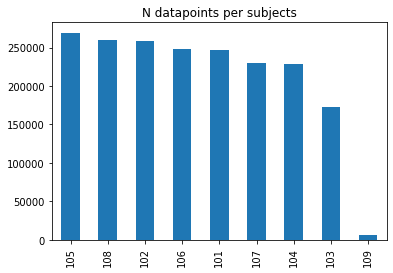

In [ ]:
subjects['id'].value_counts().plot(kind='bar')
plt.title('N datapoints per subjects')
plt.show()

### BMI
Let's now see which subject has the highest BMI:

$ BMI = \frac{weight (kg)}{height (m)^2} $

In [ ]:
subject_info['bmi'] = subject_info['Weight (kg)'] / (subject_info['Height (cm)']/100)**2
subject_info

,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand,bmi
101,Male,27,182,83,75,193,right,25.057360
102,Female,25,169,78,74,195,right,27.309968
103,Male,31,187,92,68,189,right,26.309017
104,Male,24,194,95,58,196,right,25.241790
105,Male,26,180,73,70,194,right,22.530864
106,Male,26,183,69,60,194,right,20.603780
107,Male,23,173,86,60,197,right,28.734672
108,Male,32,179,87,66,188,left,27.152711
109,Male,31,168,65,54,189,right,23.030045


In [ ]:
# BMI stats
print(f"Mean BMI: {np.mean(subject_info['bmi'])}")
print(f"St.Dev BMI: {np.std(subject_info['bmi'])}")
display(subject_info[max(subject_info['bmi']) == subject_info['bmi']])
display(subject_info[min(subject_info['bmi']) == subject_info['bmi']])

Mean BMI: 25.107800803931557
St.Dev BMI: 2.4696531234741834


,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand,bmi
107,Male,23,173,86,60,197,right,28.734672


,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),Dominant hand,bmi
106,Male,26,183,69,60,194,right,20.60378


BMI measures bodyweight compared to the subjects height:

* =< 18.5 = Underweight
* => 25 = Normal weight
* => 28.9 = Overweight
* =< 29 = Obese

The stats show that subject 107 is overweight, but this can be due to muscle weight or fat or both. The mean of the group is approximately 25 which mean that the group is about normal in their weight. I can therefore conclude that no subjects were in very poor physical health when they were tested.

## Correlation heatmap
The heatmap will show the linear relationships between every label in the dataset. White is high correlation, red is medium and black is low.

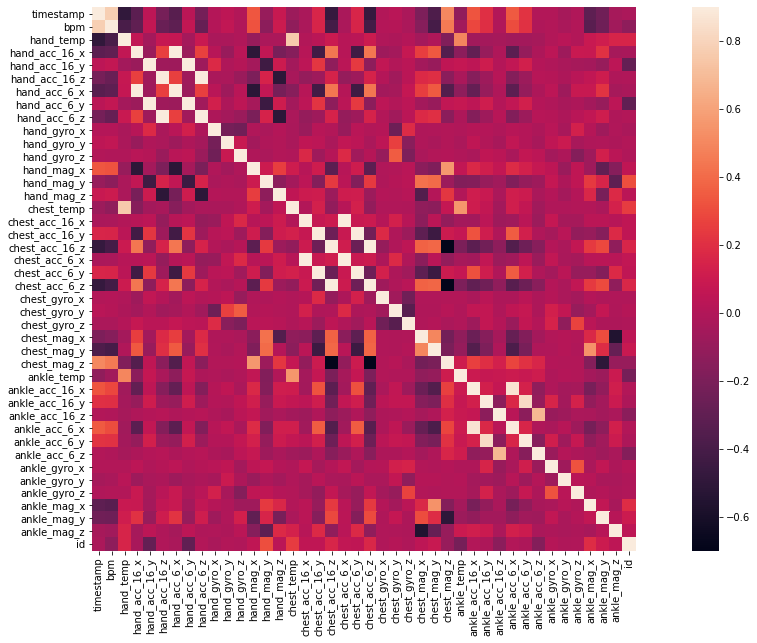

In [ ]:
corrmat = subjects.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corrmat, vmax=0.9, square=True)

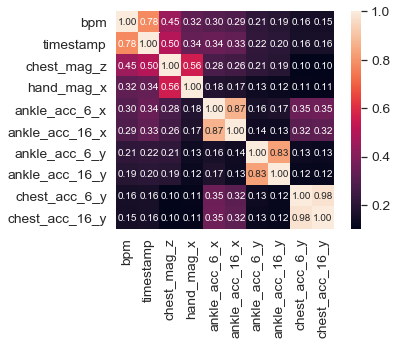

In [ ]:
k = 10
cols = corrmat.nlargest(k, 'bpm')['bpm'].index
cm = np.corrcoef(subjects[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

There is a high correlation with Timestamp and Heart rate (bpm), likely due to exhaustion.

## Analysing Temperature

Text(0, 0.5, 'Degrees celsius')

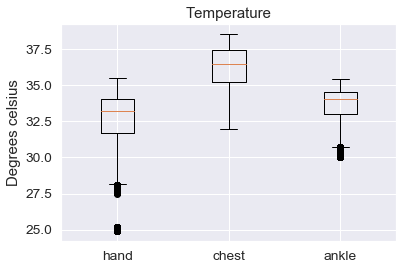

In [ ]:
plt.boxplot([subjects['hand_temp'], subjects['chest_temp'], subjects['ankle_temp']], labels=['hand', 'chest', 'ankle'])
plt.title('Temperature')
plt.ylabel('Degrees celsius')

C:\Users\joaki\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


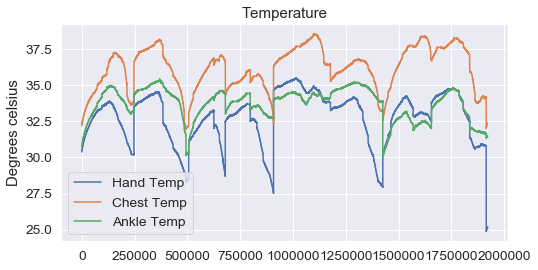

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(subjects['hand_temp'], label='Hand Temp')
plt.plot(subjects['chest_temp'], label='Chest Temp')
plt.plot(subjects['ankle_temp'], label='Ankle Temp')
plt.legend()
plt.title('Temperature')
plt.ylabel('Degrees celsius')
plt.show()

The big drops happen when the dataset drops to the next subjects.
We can see that **hands** have the lowest average temperature and **chest** has the highest. 

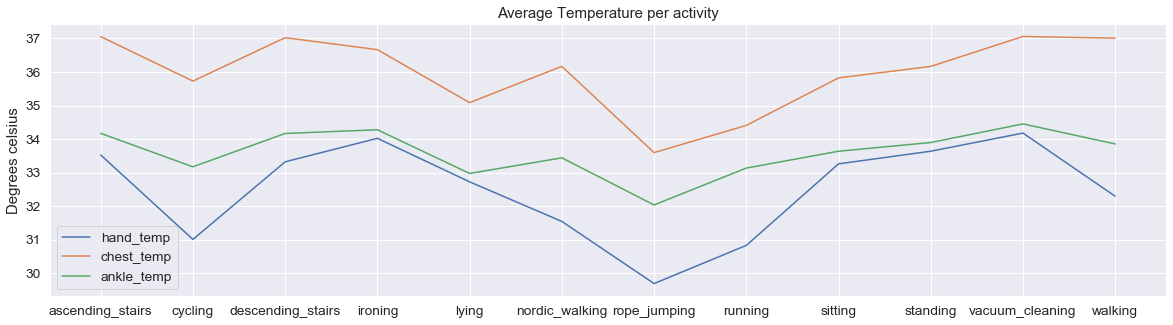

In [ ]:
act_temp = subjects.groupby(['activityID']).mean().index
hand_temp = subjects.groupby(['activityID']).mean()['hand_temp']
chest_temp = subjects.groupby(['activityID']).mean()['chest_temp']
ankle_temp = subjects.groupby(['activityID']).mean()['ankle_temp']

plt.figure(figsize=(20, 5))
plt.plot(act_temp, hand_temp, label='hand_temp')
plt.plot(act_temp, chest_temp, label='chest_temp')
plt.plot(act_temp, ankle_temp, label='ankle_temp')
plt.title('Average Temperature per activity')
plt.legend()
plt.ylabel('Degrees celsius')
plt.show()

Jump roping is the coldest activity. This is surprising and probably wrong seeing as it can be quite exhaustive. This could be due to a low representation in the dataset.

## Analysing activities

In [ ]:
# First note that from the data cleaning we have lost some value
subjects['activityID'].value_counts()

ironing              237902
walking              229709
lying                192286
standing             188984
sitting              184645
nordic_walking       184444
vacuum_cleaning      174976
cycling              163302
ascending_stairs     117094
descending_stairs    104865
running               95641
rope_jumping          47579
Name: activityID, dtype: int64

Text(0.5, 1.0, "BPM's for every activity")

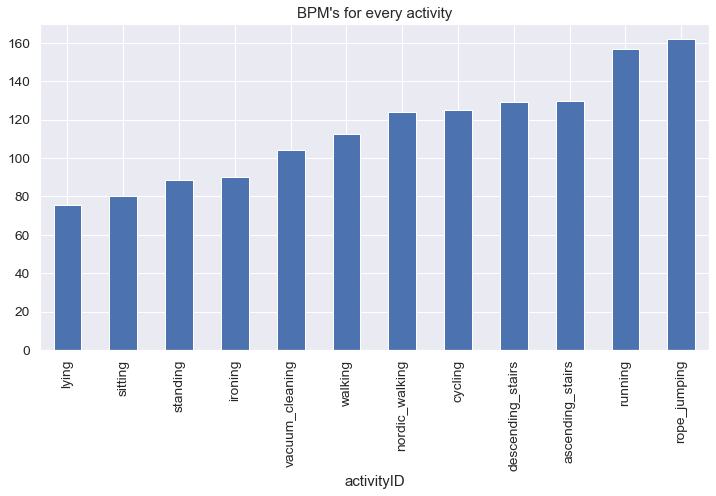

In [ ]:
subjects.groupby('activityID')['bpm'].mean().sort_values().plot(kind='bar', figsize=(12, 6))
plt.title("BPM's for every activity")

In [ ]:
subjects.groupby('activityID')['bpm'].mean().sort_values(ascending=False)

activityID
rope_jumping         161.810903
running              156.646900
ascending_stairs     129.531574
descending_stairs    129.158759
cycling              124.899581
nordic_walking       123.816170
walking              112.768643
vacuum_cleaning      104.191229
ironing               90.067612
standing              88.552778
sitting               80.015589
lying                 75.534206
Name: bpm, dtype: float64

### Heart Rate Analysis

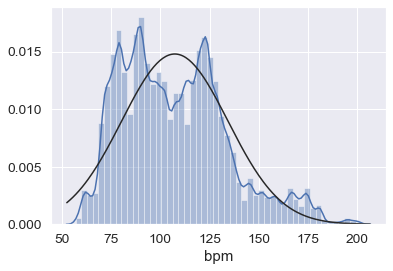

In [ ]:
sns.distplot(subjects['bpm'], fit=norm)

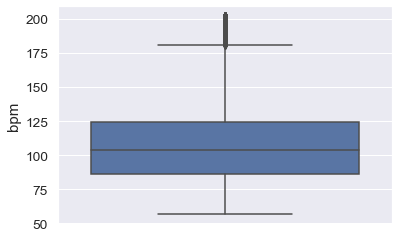

In [ ]:
sns.boxplot(y=subjects['bpm'])

# Hypothesis Testing

From our analysis of body temperature I would like to test if the body temperature for inside activities is significantly hotter than for outside activities. 
**If** this is true, **then** we can conclude that the body temperature will be more affected by outside temperature than by the physical activity. A hypothesis like this can be applied situations like how to dress and behave in a cold enviroment.

Because chest temperature is shown above to be closest to normal body temperature (37,5 C) we will use this as our measurement unit.

Household chores: 'ironing', 'vacuum cleaning', ('folding laundry', 'house cleaning' has 0 values).

Outside activities: 'running', 'cycling', 'rope_jumping', 'nordic_walking'

In [ ]:
ironing = subjects[subjects['activityID'] == 'ironing']
vacuum_cleaning = subjects[subjects['activityID'] == 'vacuum_cleaning']
inside = pd.concat([ironing, vacuum_cleaning])

running = subjects[subjects['activityID'] == 'running']
cycling = subjects[subjects['activityID'] == 'cycling']
rope_jumping = subjects[subjects['activityID'] == 'rope_jumping']
nordic_walking = subjects[subjects['activityID'] == 'nordic_walking']
outside = pd.concat([running, cycling, rope_jumping, nordic_walking])

print(f"Mean temp for household chores: {np.mean(inside['chest_temp'])}")
print(f"Mean temp for outside activities: {np.mean(outside['chest_temp'])}")

Mean temp for household chores: 36.831630802561534
Mean temp for outside activities: 35.4292803625913


To perform this hypthesis I will use the Z-test:

The Z-test is measured with the following Test Statistic: $ Z = \frac{\bar{x} - \mu}{\sigma / \sqrt{n}} $

Our level of significance will be 5%

$ H_0 = $ outside activities $ \le 35.4293 $

$ H_A = $ outside activities $ > 35.4293 $

In [ ]:
alpha = 0.05
x_bar = np.mean(inside['chest_temp'])
mu = np.mean(outside['chest_temp'])
sigma = np.std(outside['chest_temp'])
N = len(outside['chest_temp'])

Z = (x_bar - mu) / (sigma - np.sqrt(N))
print(Z)

-0.002006575155173733


"If the P is low, the null must go. If the P is high, the null must fly!"

In [ ]:
p_value = 1 - norm.cdf(Z)
if p_value > alpha:
    print(f'The P-value is {p_value} and thus we fail to reject the null hypothesis.')
else:
    print(f'The P-value is {p_value} and thus we can reject the null hypothesis for the alternative hypothesis')

The P-value is 0.5008005071310156 and thus we fail to reject the null hypothesis.


Because the P-value is higher than our level of significance we are unable to reject the null hypothesis.
This doesn't mean that the null is true by any sense, but rather that in this instance we cannot conclude that there is a statistical significance that our inside activities create higher body heat than our outside activities.

# Splitting dataset into train/test-sets
ActivityID is essential to the models, so I will use OneHotEncoding to encode the features (1 = feature exists, 0 = does not exist).

When splitting train/test sets it is common to split the two sets into 70-80% training data and the rest in testing data. I will use a 75/25 split to use on my models.

In [ ]:
df = subjects.drop(['activityID', 'id'], axis=1)

ohe_df = pd.get_dummies(subjects['activityID'], prefix='act')

x_train =  df.sample(frac=0.75, random_state=1)
x_test = df.drop(x_train.index)
y_train = ohe_df.iloc[x_train.index]
y_test = ohe_df.iloc[x_test.index]

scaler = StandardScaler()  # The standard value (x) is calculated as: z = (x - mean_of_label) / std.dev

# Always scale AFTER splitting
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=df.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=df.columns)

In [ ]:
#df = subjects.iloc[:, 0:3]
df = df.join(subjects['activityID'])

for key, value in activities.items():
    df.replace(key, value, inplace=True)
    
x = df.iloc[:, -1]
#df.drop('activityID', axis=1, inplace=True) # Dropping it seeing as it is stored in clf

cluster_train = df.sample(frac=0.75, random_state=1)
cluster_test = df.drop(cluster_train.index)
clf_train = x.iloc[cluster_train.index].values
clf_test = x.iloc[cluster_test.index].values

cluster_train = pd.DataFrame(scaler.fit_transform(X=cluster_train, y=cluster_train['activityID']), columns=df.columns)
cluster_test = pd.DataFrame(scaler.fit_transform(X=cluster_test, y=cluster_test['activityID']), columns=df.columns)

## Dimensionality Reduction with the use of PCA
To use PCA as a dimensionality reductor we first need to decide the number of principal components that are necessary to explain 95% of the data.

Text(0.5, 0, 'N componments')

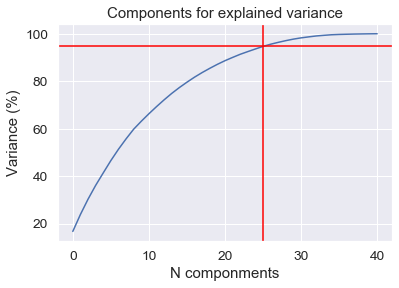

In [ ]:
pca = PCA()
pca.fit(x_train)
pca_variance = np.cumsum(pca.explained_variance_ratio_) * 100

plt.plot(pca_variance)
#plt.grid()
#plt.xlim(0, 50)
#plt.ylim(90, 101)
plt.axhline(95, c='red')
plt.axvline(25, c='red')
plt.title("Components for explained variance")
plt.ylabel("Variance (%)")
plt.xlabel("N componments")

If we use 25 components it will cover 95% of the variance in our dataset

In [ ]:
pca = PCA(n_components=25)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

# ML-Modelling

## Supervised Learning

In [ ]:
def fit_ml_algo(algo, x_train, y_train, x_test, y_test, cv):
    """This algorithm will fit and run the regression model to the data and print the cross validated scores."""
    
    model = algo.fit(x_train, y_train)
    train_pred = cross_val_predict(algo, x_train, y_train, cv=cv, n_jobs=(-1))
    test_pred = cross_val_predict(algo, x_test, y_test, cv=cv, n_jobs=(-1))
    train_acc_cv = round(accuracy_score(y_train, train_pred) * 100, 2)
    test_acc_cv = round(accuracy_score(y_test, test_pred) * 100, 2)
    
    return train_pred, test_pred, train_acc_cv, test_acc_cv

### Logistic Regression

In [ ]:
n_cv = 10 # Number of times we cross-validate the data
res = []

for col in y_train.columns:
    start_time = time.time()
    train_pred, test_pred, train_acc, test_acc = fit_ml_algo(LogisticRegression(),
                                                             x_train,
                                                             y_train[col],
                                                             x_test,
                                                             y_test[col],
                                                             n_cv)
    log_time = time.time() - start_time
    
    print(col)
    print(f"CV Accuracy Train {n_cv}-fold: {train_acc}")
    print(f'CV Accuracy Test {n_cv}-fold: {test_acc}')
    print(f"Running Time: {datetime.timedelta(seconds=log_time)}")
    print(" ") # Spacing the prints
    res.append(test_acc)

act_ascending_stairs
CV Accuracy Train 10-fold: 94.38
CV Accuracy Test 10-fold: 93.34
Running Time: 0:00:50.187795
 
act_cycling
CV Accuracy Train 10-fold: 97.53
CV Accuracy Test 10-fold: 96.03
Running Time: 0:01:01.480525
 
act_descending_stairs
CV Accuracy Train 10-fold: 95.21
CV Accuracy Test 10-fold: 93.72
Running Time: 0:00:46.412910
 
act_ironing
CV Accuracy Train 10-fold: 94.74
CV Accuracy Test 10-fold: 89.47
Running Time: 0:01:03.503402
 
act_lying
CV Accuracy Train 10-fold: 99.52
CV Accuracy Test 10-fold: 97.88
Running Time: 0:02:24.811014
 
act_nordic_walking
CV Accuracy Train 10-fold: 88.31
CV Accuracy Test 10-fold: 86.37
Running Time: 0:00:44.683532
 
act_rope_jumping
CV Accuracy Train 10-fold: 98.37
CV Accuracy Test 10-fold: 96.38
Running Time: 0:01:12.260489
 
act_running
CV Accuracy Train 10-fold: 96.55
CV Accuracy Test 10-fold: 95.88
Running Time: 0:01:02.802387
 
act_sitting
CV Accuracy Train 10-fold: 96.28
CV Accuracy Test 10-fold: 90.36
Running Time: 0:01:44.306623
 

In [ ]:
print(f"Average accuracy: {np.mean(res)}")
print(f"Median accuracy: {np.median(res)}")
print(f"Standard Deviation of the accuracy: {np.std(res)}")

Average accuracy: 92.61416666666666
Median accuracy: 93.11500000000001
Standard Deviation of the accuracy: 3.6135726973300084


We note that the accuracy of the training data is generally higher than the test data. However, test accuracy is still very high and return accuracy of >90% for most of the activities.

## Cluster Analysis (Unsupervised Learning)

**Activity Segmentation:** I want to see if I can use cluster analysis to define certain activities with K-Means Clustering. To start with I am going to make a cluster with all 12 activities that are represented in the dataset, then I am going to use the Elbow Method to find the number of clusters that are optimal for using in the scatter plot.

But first I need to find the most optimal feature labels to use for visualising the dataset. I do this by using PCA again.

From this I can see that the most explanatory labels to use in the plot is:

x-axis = **Timestamp**\
y-axis = **Heart Rate (bpm)**

In [ ]:
clf_train = pd.DataFrame(clf_train, columns=['train'])

kmeans = KMeans(n_clusters=len(np.unique(clf_train)), init='random')

kmeans.fit(clf_train)

identified_clusters = kmeans.fit_predict(clf_train)
clf_train['identified'] = identified_clusters
print(identified_clusters)

[ 3  6  3 ...  5 11  2]


C:\Users\joaki\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


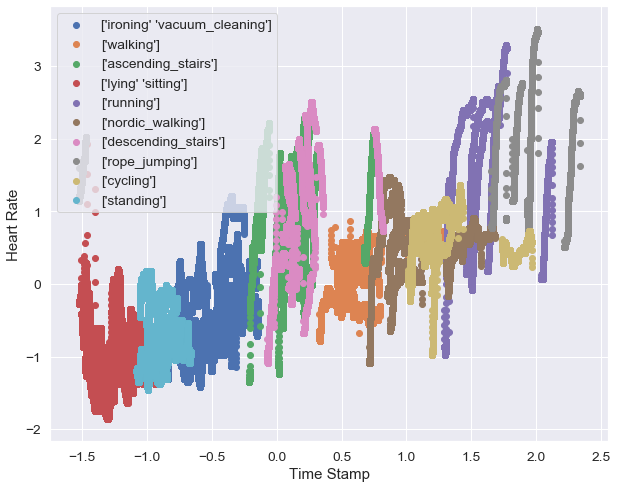

In [ ]:
for key, value in activities.items():
    clf_train['train'].replace(value, key, inplace=True)

plt.figure(figsize=(10, 8))
for u in np.unique(clf_train['identified']):
    plt.scatter(cluster_train[clf_train['identified'] == u]['timestamp'],
               cluster_train[clf_train['identified'] == u]['bpm'], 
               label=np.unique(clf_train[clf_train['identified'] == u]['train']))
plt.legend()
plt.xlabel('Time Stamp')
plt.ylabel('Heart Rate')
plt.show()

This cluster we can see the segmentation of all activities represented in our dataset.\
Now I wan't to try using the elbow method to possibly improve the dataset.

In [ ]:
wcss = []

for i in range(1, 13):
    kmeans = KMeans(i)
    kmeans.fit(pd.DataFrame(clf_train['identified'])) # The kmeans couldn't fit with anything else than a pd.DataFrame
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

C:\Users\joaki\anaconda3\lib\site-packages\ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  """
C:\Users\joaki\anaconda3\lib\site-packages\ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  """


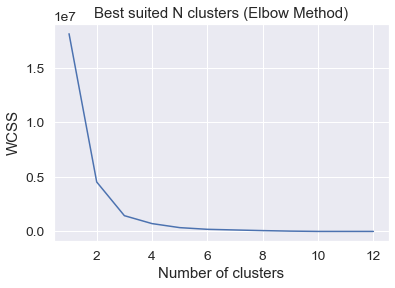

In [ ]:
number_clusters = range(1, 13)
plt.plot(number_clusters, wcss)
plt.title('Best suited N clusters (Elbow Method)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The graph tells us that the optimal number of clusters to use is 2.

In [ ]:
kmeans = KMeans(n_clusters=2, init='random')

kmeans.fit(pd.DataFrame(clf_train['identified']))

identified_clusters = kmeans.fit_predict(pd.DataFrame(clf_train['identified']))

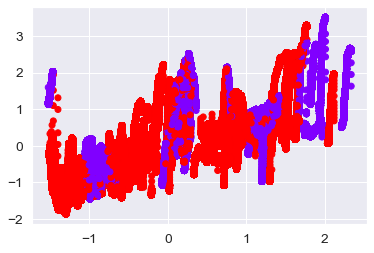

In [ ]:
plt.scatter(cluster_train['timestamp'], cluster_train['bpm'], c=identified_clusters, cmap='rainbow')
plt.show()

This cluster is very hard to interpret, so we can conclude that it is not useful to use the Elbow Method for the K-Means Clustering 

# Summary

I've have imported and pre-processed the data from PAMAP2 website(http://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring). Then I removed outliers from every feature label except heart-rate which we filled with their respective interpolated values.

When the data was pre-processed I started the data analysis on temperature, activityIDs and the heart-rate before making a hypothetical test of significance. Here I used a Z-test to see if indoor activities had significant higher body temperatures than outdoor activities, but there was no statistical significance for this hypothesis.

Finally I normalized the data using Standard Scaler created a binary value for each dependent variable (activities) before I used Principal Component Analysis to find the optimal number of principal components (24) that explained 95% of the data and ran it through a Logistic Regression. This resulted in test results that showed approximately 93% accuracy in determining which activities that was being conducted at every level. To top it of I made a cluster analysis using K-Means Clustering where I classified all the activities. However, using the Elbow Method to find the optimal number of clusters wasn't very clear in this scenario.